In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [2]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.initializers import Constant
from keras.layers import *
from keras.utils import to_categorical

import os
import pandas as pd
import numpy as np
from numpy import array
import re

Using TensorFlow backend.


In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_probation']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_probation'])

In [4]:
df_0 = df[df['y_probation'] == 0].sample(frac=1)
df_1 = df[df['y_probation'] == 1].sample(frac=1)

sample_size = 1042

df = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [5]:
X = df.drop('y_probation', axis=1)
y = to_categorical(df['y_probation'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]


In [8]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = pad_sequences(X3_train, sequence_length)
X3_test = pad_sequences(X3_test, sequence_length)

In [9]:
input_1 = Input(shape=(687,))
input_2 = Input(shape=(662,))

dense_layer_1_1 = Dense(50, activation='relu')(input_1)
dense_layer_1_2 = Dense(10, activation='relu')(dense_layer_1_1)
dense_layer_1_3 = Dense(10, activation='relu')(dense_layer_1_2)
dense_layer_1_4 = Dense(10, activation='relu')(dense_layer_1_3)
dropout_1_5 = Dropout(0.2)(dense_layer_1_4)


dense_layer_2_1 = Dense(50, activation='relu')(input_2)
dense_layer_2_2 = Dense(10, activation='relu')(dense_layer_2_1)
dense_layer_2_3 = Dense(10, activation='relu')(dense_layer_2_2)
dense_layer_2_4 = Dense(10, activation='relu')(dense_layer_2_3)
dropout_2_5 = Dropout(0.2)(dense_layer_2_4)

In [10]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

17584


In [11]:
input_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_3_3 = Conv2D(num_filters, kernel_size=(6, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)
maxpool_3_3 = MaxPool2D(pool_size=(sequence_length - 6 + 1, 1), strides=(1,1), padding='valid')(conv_3_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3, maxpool_3_3])
flatten_3 = Flatten()(concatenated_tensor_3)
dropout_3 = Dropout(0.2)(flatten_3)
#dense_layer_3 = Dense(12, activation='relu')(dropout_3)

In [12]:
concat_layer = Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = Dense(50, activation='relu')(concat_layer)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(10, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(10, activation='relu')(dense_layer_5)

output = Dense(2, activation='softmax')(dense_layer_6)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 128)     2250752     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 687)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 662)          0                                            
____________________________________________________________________________________________

In [14]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=50, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1687 samples, validate on 188 samples
Epoch 1/50
1687/1687 [==============================] - 3s 2ms/step - loss: 4.5556 - acc: 0.4914 - val_loss: 0.7272 - val_acc: 0.4840
Epoch 2/50
1687/1687 [==============================] - 1s 335us/step - loss: 0.7021 - acc: 0.5282 - val_loss: 0.7011 - val_acc: 0.5638
Epoch 3/50
1687/1687 [==============================] - 1s 346us/step - loss: 0.7033 - acc: 0.6129 - val_loss: 0.7080 - val_acc: 0.5426
Epoch 4/50
1687/1687 [==============================] - 1s 327us/step - loss: 0.7073 - acc: 0.6509 - val_loss: 0.7090 - val_acc: 0.6330
Epoch 5/50
1687/1687 [==============================] - 1s 331us/step - loss: 0.7097 - acc: 0.6627 - val_loss: 0.7115 - val_acc: 0.6543
Epoch 6/50
1687/1687 [==============================] - 1s 327us/step - loss: 0.7113 - acc: 0.6846 - val_loss: 0.7118 - val_acc: 0.7181
Epoch 7/50
1687/1687 [==============================] - 1s 344us/step - loss: 0.7134 - acc: 0.7024 - val_loss: 0.7127 - val_acc: 0.7340
Epo

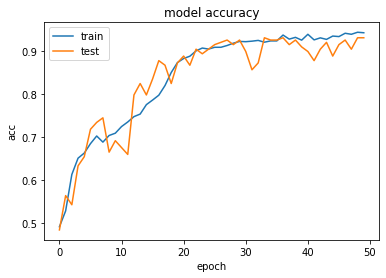

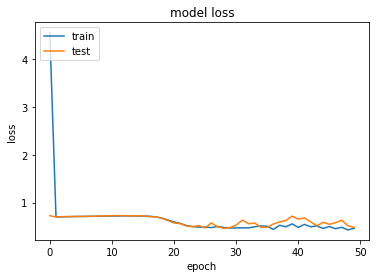

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

209/209 [==============================] - 0s 615us/step
Test Score: 0.5318223771296049
Test ACC: 0.9043062329292297
